# Instrument Parameter Sensitivity Studies

## Derived from Requirement Derivation, L1-1 Global Point Sources



In [1]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM, Printf
include("../forwardModel.jl")
using CairoMakie, DelimitedFiles, Statistics, Interpolations, NCDatasets, InstrumentOperator, LinearAlgebra
using Unitful, UnitfulEquivalences
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
include(joinpath(dirname(pathof(CarbonI)), "readSun.jl"))
include(joinpath(dirname(pathof(CarbonI)), "Requirements", "common.jl"))
using LaTeXStrings
set_theme!(theme_ggplot2())

  Activating project at `~/src/CarbonI-drt`


In [2]:
# Define numbers from L1 Requirements - this part duplicates Level1-Req-1.ipynb

# Flux limits:
flux_detect_ch4_req = 175.0u"kg/hr"    # in kg CH4/hr
flux_detect_co2_req = 100e3u"kg/hr"    # in kg CO2/hr
flux_detect_co_req  = 1.75e3u"kg/hr"   # in kg CO/hr

# GSD, required and CBE
gsd_req  = [400.0u"m", 400.0u"m"]      # in m
gsd_cbe  = [303.0u"m", 345.0u"m"]      # in m

2-element Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}:
 303.0 m
 345.0 m

In [3]:
# Effective Pixel Sizes
req_pix = sqrt(prod(gsd_req));
cbe_pix = sqrt(prod(gsd_cbe));

In [4]:
# Define constants:
m = CarbonI.molar_mass()
C = CarbonI.Constants()
preFac = C.g * m.air / C.p

# q=2 for detection limits
q = 2.0
# Wind speed for the reference scenario
wind_speed = 2.0u"m/s"
# Value of the prefactor (a constant for a given surface pressure)
@show C.g * m.air / C.p

(C.g * m.air) / C.p = 2.841957e-6 m² mol⁻¹


2.841957e-6 m² mol⁻¹

In [5]:
σ_ch4_req = flux_detect_ch4_req * preFac / req_pix / m.ch4 / wind_speed / q
σ_co2_req = flux_detect_co2_req * preFac / req_pix / m.co2 / wind_speed / q
σ_co_req  = flux_detect_co_req  * preFac / req_pix / m.co  / wind_speed / q

@show uconvert(u"ppb", σ_ch4_req)
@show uconvert(u"ppm", σ_co2_req)
@show uconvert(u"ppb", σ_co_req)

@printf("Required Single Measurement Precision for CH₄ : %.3g ppb\n",  ustrip(uconvert(u"ppb", σ_ch4_req)))
@printf("Required Single Measurement Precision for CO₂ : %.3g ppm\n",  ustrip(uconvert(u"ppm", σ_co2_req)))
@printf("Required Single Measurement Precision for CO  : %.3g ppb\n",  ustrip(uconvert(u"ppb", σ_co_req)))

uconvert(u"ppb", σ_ch4_req) = 5.383053596477556 ppb
uconvert(u"ppm", σ_co2_req) = 1.1210981879118382 ppm
uconvert(u"ppb", σ_co_req) = 30.82619767493752 ppb
Required Single Measurement Precision for CH₄ : 5.38 ppb
Required Single Measurement Precision for CO₂ : 1.12 ppm
Required Single Measurement Precision for CO  : 30.8 ppb


In [101]:
# Use the tropical scenario
scenario = CarbonI.stressing_scenario();

# Load CBE specs
cbe_specs = CarbonI.build_instrument("CBE");

# Load Required specs
req_specs = CarbonI.build_instrument("Requirement");

# Modify Exposure Time for 400m pixels
req_specs.ET = 57.0u"ms"
cbe_specs.ET = 57.0u"ms"

(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[205.17984, 205.28577, 204.3511, 205.65045, 211.39908, 219.25983, 225.50705, 229.22559, 234.98184, 241.08362, 247.89389, 254.52339, 259.31662, 260.55365, 261.2295, 260.91293, 257.9075, 254.52269, 250.68933, 247.50629, 245.75996, 242.73718, 241.07652, 237.61713, 235.17921, 236.70642, 230.41078, 229.94821, 222.20546, 218.0587, 214.88086, 212.21912, 209.32239, 206.50714, 197.59671, 192.69617, 194.36191, 199.31332, 201.06302, 203.26447, 209.37901, 217.33842, 226.74182, 236.74905, 245.94034, 253.06683, 256.719, 261.30786, 265.14124, 268.4499, 271.63074, 274.55365, 276.77612, 279.03894, 281.011, 282.8612, 284.70425, 286.3738, 287.6122, 288.7355, 289.78403, 290.64203, 290.84982, 291.21863, 292.01584, 293.05814, 294.24646, 295.5233, 296.82358, 298.12357, 299.40927, 300.6187]


57.0 ms

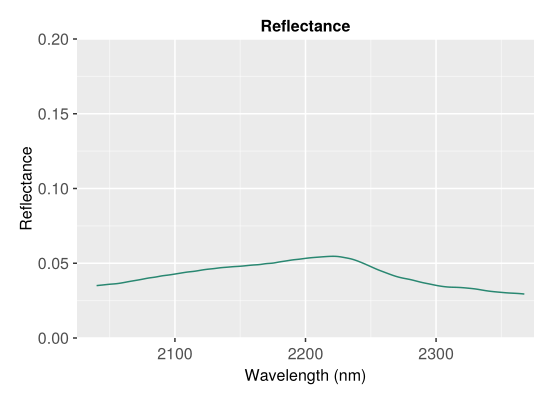

In [102]:
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Reflectance",  title="Reflectance")
lines!(ax,req_specs.instrument_wl,scenario.surface_albedo(req_specs.instrument_wl),
    color=CarbonI_colors[3],label="Reflectance")
xlims!(ax,2025,2375)
ylims!(ax,0,0.2)
save("/Users/drt/src/CarbonI-drt/plots/final/ScenarioReflectance.pdf",f)
f

In [105]:
# Create required Instrument model but with 57 ms integration time
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
        req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);

In [106]:
# Get reflectance here
wll = req_specs.modelling_wl;
refl_req   = scenario.surface_albedo(wll);
refl_cbe   = scenario.surface_albedo(wll);

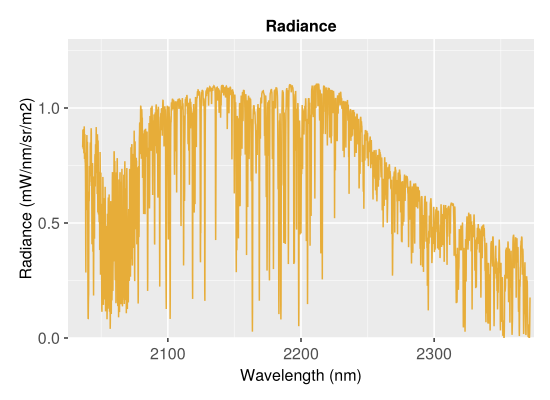

In [107]:
# Illustrate the radiance at sensor using high-spectral-resolution sampling
# Construct a forward model for the reference case

include("/Users/drt/src/CarbonI-drt/src/Requirements/instrument.jl")

fine_inst = build_instrument(
        FPA_quantum_efficiency = 0.88,
        bench_efficiency = 0.657,
        readout_noise = 101.5, # Includes quantization error
        dark_current = 3e3u"1/s",
        SSI = 0.1u"nm",
        FWHM = 0.1,
        FWHM_gaussian = 0.1,
        lower_wavelength = 2036.0,
        upper_wavelength = 2372.0,
        pixel_size_global = 345u"m",
        pixel_size_target = 34.5u"m"
    )

co2, ch4, h2o, hdo, n2o, co, co2_iso2, c2h6 = CarbonI.loadXSModels();
DS = Dataset(CarbonI.solar_file)
wlSol = 1e3*DS["wl"][:]
solar_irr = 1e3*DS["solar_irr"][:] # convert to mW/m2/nm
close(DS) 
hitran_array = (co2, h2o, ch4, co, n2o, hdo, co2_iso2, c2h6);
	
# Precompute the cross sections:
σ_matrix_hr = CarbonI.compute_profile_crossSections(scenario.profile_hr, hitran_array , req_specs.modelling_wl);

nL = length(scenario.profile_hr.T)
    
vmr_co2 = zeros(nL) .+ 407e-6
vmr_ch4 = zeros(nL) .+ 1.8e-6
vmr_ch4[1:3] .= 1.4e-6
vmr_h2o = scenario.profile_hr.vcd_h2o ./ scenario.profile_hr.vcd_dry
vmr_co  = zeros(nL) .+ 100e-9
vmr_n2o = zeros(nL) .+ 337e-9
vmr_n2o[1:3] .= 100e-9
vmr_hdo = vmr_h2o * 0.9
vmr_c2h6 = zeros(nL) .+ 1.0e-9
vmrs = [vmr_co2, vmr_h2o, vmr_ch4,vmr_co, vmr_n2o, vmr_hdo, vmr_co2, vmr_c2h6];

sol  = CubicSplineInterpolation(range(wlSol[1],wlSol[end], length=length(wlSol)),solar_irr, extrapolation_bc=Interpolations.Flat());

n_layers = 10;
profile, σ_matrix, indis, gasProfiles = CarbonI.reduce_profile(n_layers, scenario.profile_hr, σ_matrix_hr,vmrs)
nLeg = 10
xPoly = zeros(nLeg).+eps()
xPoly[1] = 1.0
x = [reduce(vcat,gasProfiles) ; xPoly ];

# Plot radiance and resampled radiance
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Radiance (mW/nm/sr/m2)",  title="Radiance")
q=forward_model_x_(x, 
						 sun=solarIrr_req, 
						 instrument=fine_inst.instrument_kernel,
			             reflectance=refl_req, 
			             sza=scenario.sza, 
			             σ_matrix=σ_matrix, 
					     profile=profile,
			             wl=fine_inst.modelling_wl)

q2=forward_model_x_(x, 
						 sun=solarIrr_req, 
						 instrument=req_specs.instrument_kernel,
			             reflectance=refl_req, 
			             sza=scenario.sza, 
			             σ_matrix=σ_matrix, 
					     profile=profile,
			             wl=req_specs.modelling_wl)

lines!(ax,fine_inst.instrument_wl,q,color=CarbonI_colors[1],label="Simulated Reflected Radiance")
#axislegend(ax,position = :lt)
xlims!(ax,2025,2375)
ylims!(ax,0,1.3)
save("/Users/drt/src/CarbonI-drt/plots/final/SimulatedRadiance.pdf",f)
f

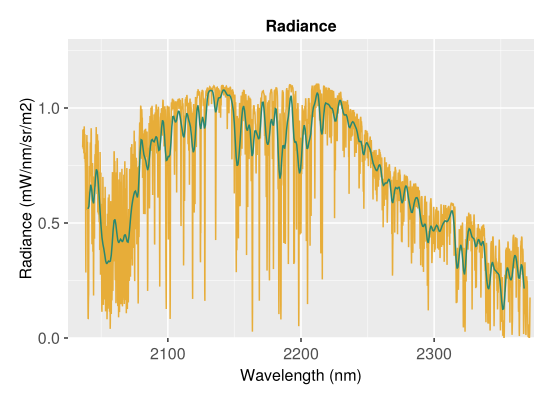

In [108]:
# Illustrate the resampling
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Radiance (mW/nm/sr/m2)",  title="Radiance")
lines!(ax,fine_inst.instrument_wl,q,color=CarbonI_colors[1],label="Radiance")
lines!(ax,req_specs.instrument_wl,q2,color=CarbonI_colors[3],label="Radiance")
xlims!(ax,2025,2375)
ylims!(ax,0,1.3)
save("/Users/drt/src/CarbonI-drt/plots/final/ResampledRadiance.pdf",f)
f

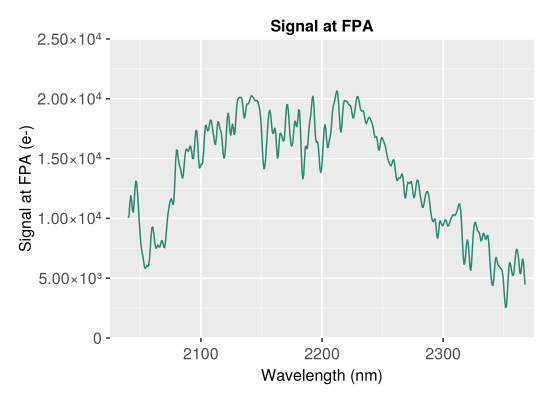

In [109]:
# Show signal at FPA
signal = InstrumentOperator.photons_at_fpa(ins_req, (req_specs.instrument_wl)u"nm", (q2)u"mW/m^2/nm/sr")
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Signal at FPA (e-)",  title="Signal at FPA")
lines!(ax,req_specs.instrument_wl,signal,color=CarbonI_colors[3],label="Signal")
xlims!(ax,2025,2375)
ylims!(ax,0,25000)
save("/Users/drt/src/CarbonI-drt/plots/final/SignalAtFPA.pdf",f)
f

In [110]:
error_req, F_req = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req, Sₐ_req, return_F=true) 
error_cbe, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe, Sₐ_cbe, return_F=true); 

In [111]:
sqrtN = sqrt(req_specs.coadd_rate)

3.1622776601683795

In [112]:
@printf("Expected Single Measurement Precision for CH₄ : %.3g ppb\n",  error_cbe["ch4"]/sqrtN)
@printf("Expected Single Measurement Precision for CO₂ : %.3g ppm\n",  error_cbe["co2"]/1000/sqrtN)
@printf("Expected Single Measurement Precision for CO  : %.3g ppb\n",  error_cbe["co"]/sqrtN)
@printf("Expected Single Measurement Precision for N₂O  : %.3g ppb\n",  error_cbe["n2o"]/sqrtN)

Expected Single Measurement Precision for CH₄ : 5.96 ppb
Expected Single Measurement Precision for CO₂ : 1.08 ppm
Expected Single Measurement Precision for CO  : 28.8 ppb
Expected Single Measurement Precision for N₂O  : 10.3 ppb


In [115]:
# Now get total efficiency at different F-numbers
fnumbers = 2.0:0.1:3
gas_errors_fnumber_100 = zeros(4,length(fnumbers))
gas_errors_fnumber_120 = zeros(4,length(fnumbers))
for (i,fnumber) in enumerate(fnumbers)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 400m pixels along track dimension)
    efficiency = cbe_specs.FPA_quantum_efficiency * cbe_specs.bench_efficiency
    ins_cbe_100 = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 1.0, efficiency, fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current); 
    ins_cbe_120 = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 1.0, efficiency, fnumber, 2*cbe_specs.SSI, (120.0), cbe_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_100, Sₐ_cbe) 
    error_varied_120 = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_120, Sₐ_cbe) 
    # Store Data
    gas_errors_fnumber_100[1,i] = error_varied_100["ch4"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_fnumber_120[1,i] = error_varied_120["ch4"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_fnumber_100[2,i] = error_varied_100["co2"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_fnumber_120[2,i] = error_varied_120["co2"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_fnumber_100[3,i] = error_varied_100["co"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_fnumber_120[3,i] = error_varied_120["co"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_fnumber_100[4,i] = error_varied_100["n2o"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_fnumber_120[4,i] = error_varied_120["n2o"]/sqrt(cbe_specs.coadd_rate) 
    println(gas_errors_fnumber_100[1,i])
end

5.187658075710752
5.5490874181389565
5.923511482217143
6.311080101235042
6.711934520518653
7.126207641850533
7.554024322619351
7.995501707714622
8.450749579055218
8.919870712339161
9.402961233816995


In [116]:
# Now get total efficiency at different Dark Currents
darkcurrents = 2000.0:1000.0:10000.0
gas_errors_darkcurrent_100 = zeros(4,length(darkcurrents))
gas_errors_darkcurrent_120 = zeros(4,length(darkcurrents))
for (i,darkcurrent) in enumerate(darkcurrents)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for cbe. as we count 400m pixels along track dimension)
    efficiency = cbe_specs.FPA_quantum_efficiency * cbe_specs.bench_efficiency
    ins_cbe_100 = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 1.0, efficiency, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), (darkcurrent)u"s^-1"); 
    ins_cbe_120 = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 1.0, efficiency, cbe_specs.Fnumber, 2*cbe_specs.SSI, (120.0), (darkcurrent)u"s^-1"); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_100, Sₐ_cbe) 
    error_varied_120 = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_120, Sₐ_cbe) 
    # Store Data
    gas_errors_darkcurrent_100[1,i] = error_varied_100["ch4"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_darkcurrent_120[1,i] = error_varied_120["ch4"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_darkcurrent_100[2,i] = error_varied_100["co2"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_darkcurrent_120[2,i] = error_varied_120["co2"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_darkcurrent_100[3,i] = error_varied_100["co"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_darkcurrent_120[3,i] = error_varied_120["co"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_darkcurrent_100[4,i] = error_varied_100["n2o"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_darkcurrent_120[4,i] = error_varied_120["n2o"]/sqrt(cbe_specs.coadd_rate) 
    println(gas_errors_darkcurrent_100[1,i])
end

5.916404961767348
5.923511482217143
5.930607041166673
5.937691698955059
5.944765515311875
5.951828549366412
5.958880859656422
5.965922504136878
5.972953540188634


In [117]:
# Now get total efficiency at different integration times
integrations = (37.0:10.0:77.0)
gas_errors_integration_100 = zeros(4,length(integrations))
gas_errors_integration_120 = zeros(4,length(integrations))
for (i,integration) in enumerate(integrations)
    # Create instrument Specs here:
    efficiency = cbe_specs.FPA_quantum_efficiency * cbe_specs.bench_efficiency
    ins_cbe_100 = InstrumentOperator.createGratingNoiseModel((integration)u"ms", cbe_specs.Pitch, 1.0, efficiency, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current); 
    ins_cbe_120 = InstrumentOperator.createGratingNoiseModel((integration)u"ms", cbe_specs.Pitch, 1.0, efficiency, cbe_specs.Fnumber, 2*cbe_specs.SSI, (120.0), cbe_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_100, Sₐ_cbe) 
    error_varied_120 = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_120, Sₐ_cbe) 
    # Store Data
    gas_errors_integration_100[1,i] = error_varied_100["ch4"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_integration_120[1,i] = error_varied_120["ch4"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_integration_100[2,i] = error_varied_100["co2"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_integration_120[2,i] = error_varied_120["co2"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_integration_100[3,i] = error_varied_100["co"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_integration_120[3,i] = error_varied_120["co"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_integration_100[4,i] = error_varied_100["n2o"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_integration_120[4,i] = error_varied_120["n2o"]/sqrt(cbe_specs.coadd_rate) 
    println(gas_errors_integration_100[1,i])
end

8.120739504092308
6.800322600825661
5.923511482217143
5.294882370077951
4.8197380387460145


In [118]:
# Now float total efficiency 
efficiencies = (0.3:0.05:0.7)
gas_errors_efficiency_100 = zeros(4,length(efficiencies))
gas_errors_efficiency_120 = zeros(4,length(efficiencies))
for (i,efficiency) in enumerate(efficiencies)
    # Create instrument Specs here:
    ins_cbe_100 = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 1.0, efficiency, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current); 
    ins_cbe_120 = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 1.0, efficiency, cbe_specs.Fnumber, 2*cbe_specs.SSI, (120.0), cbe_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_100, Sₐ_cbe) 
    error_varied_120 = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_120, Sₐ_cbe) 
    # Store Data
    gas_errors_efficiency_100[1,i] = error_varied_100["ch4"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_efficiency_120[1,i] = error_varied_120["ch4"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_efficiency_100[2,i] = error_varied_100["co2"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_efficiency_120[2,i] = error_varied_120["co2"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_efficiency_100[3,i] = error_varied_100["co"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_efficiency_120[3,i] = error_varied_120["co"]/sqrt(cbe_specs.coadd_rate) 
    gas_errors_efficiency_100[4,i] = error_varied_100["n2o"]/sqrt(cbe_specs.coadd_rate)
    gas_errors_efficiency_120[4,i] = error_varied_120["n2o"]/sqrt(cbe_specs.coadd_rate) 
    println(gas_errors_efficiency_100[1,i])
end

9.670266924355346
8.578676098313176
7.7507510922897715
7.099619231014889
6.57298057775338
6.137433905321803
5.77062801952422
5.4570287066878755
5.185495624198984


In [126]:
ch4_req_ppb = ustrip(uconvert(u"ppb", σ_ch4_req))
co2_req_ppb = ustrip(uconvert(u"ppb", σ_co2_req))
co_req_ppb  = ustrip(uconvert(u"ppb", σ_co_req))
n2o_req_ppb = 0.043*330 
gas_errors_fnumber_120[4,:]./330

11-element Vector{Float64}:
 0.029019438389930544
 0.0310236519932975
 0.03309748813617257
 0.03524230598898684
 0.03745934712210607
 0.039749744783158826
 0.042114532648920025
 0.04455465302500122
 0.0470709644832095
 0.04966424893939314
 0.052335218184373054

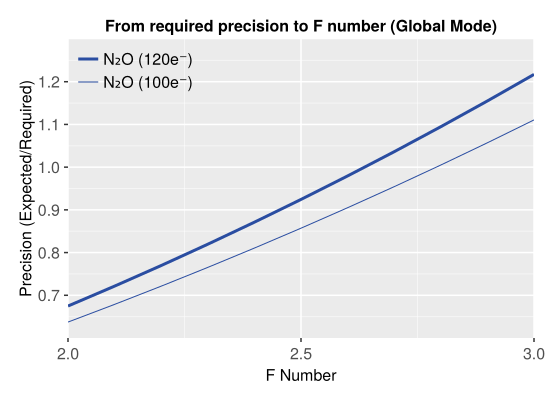

In [136]:
# Plot N2O performance vs. f number
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="F Number", ylabel="Precision (Expected/Required)",  title="From required precision to F number (Global Mode)")
lines!(ax, fnumbers, gas_errors_fnumber_120[4,:]./n2o_req_ppb, color=CarbonI_colors[4], linewidth=3, label="N₂O (120e⁻)")
lines!(ax, fnumbers, gas_errors_fnumber_100[4,:]./n2o_req_ppb, color=CarbonI_colors[4], linewidth=1, label="N₂O (100e⁻)")
xlims!(ax,2.0,3)
ylims!(ax,0.6,1.3)
axislegend(ax,position = :lt)
save("../../plots/final/SensitivityStudy_Fnumber_N2O.pdf",f)
f

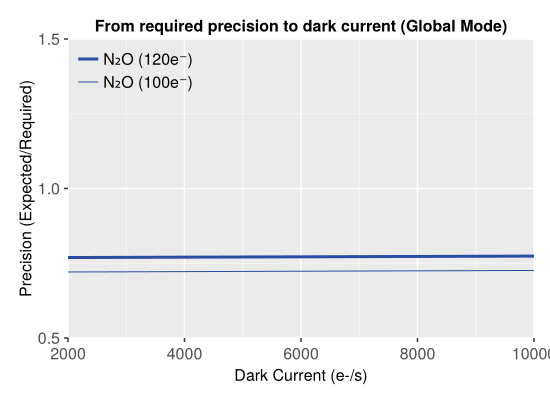

In [137]:
# Plot N2O performance vs. dark current
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Dark Current (e-/s)", ylabel="Precision (Expected/Required)",  title="From required precision to dark current (Global Mode)")
lines!(ax, darkcurrents, gas_errors_darkcurrent_120[4,:]./n2o_req_ppb, color=CarbonI_colors[4], linewidth=3, label="N₂O (120e⁻)")
lines!(ax, darkcurrents, gas_errors_darkcurrent_100[4,:]./n2o_req_ppb, color=CarbonI_colors[4], linewidth=1, label="N₂O (100e⁻)")
ylims!(ax,0.5,1.5)
xlims!(ax,2000,10000)
axislegend(ax,position = :lt)
save("../../plots/final/SensitivityStudy_darkcurrent_N2O.pdf",f)
f

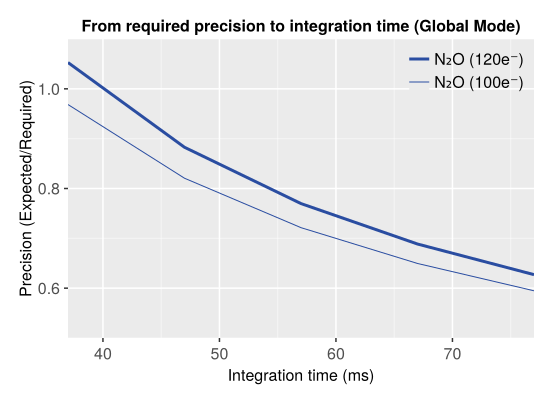

In [138]:
# Plot N2O Performance vs. integration time
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Integration time (ms)", ylabel="Precision (Expected/Required)",  title="From required precision to integration time (Global Mode)")
lines!(ax, integrations, gas_errors_integration_120[4,:]./n2o_req_ppb, color=CarbonI_colors[4], linewidth=3, label="N₂O (120e⁻)")
lines!(ax, integrations, gas_errors_integration_100[4,:]./n2o_req_ppb, color=CarbonI_colors[4], linewidth=1, label="N₂O (100e⁻)")
ylims!(ax,0.5,1.1)
xlims!(ax,37,77)
axislegend(ax,position = :rt)
save("../../plots/final/SensitivityStudy_integration_N2O.pdf",f)
f

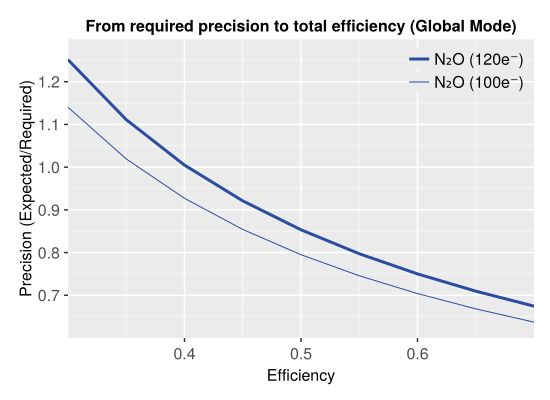

In [141]:
# Plot N2O performance vs. efficiency
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Efficiency", ylabel="Precision (Expected/Required)",  title="From required precision to total efficiency (Global Mode)")
lines!(ax, efficiencies, gas_errors_efficiency_120[4,:]./n2o_req_ppb, color=CarbonI_colors[4], linewidth=3, label="N₂O (120e⁻)")
lines!(ax, efficiencies, gas_errors_efficiency_100[4,:]./n2o_req_ppb, color=CarbonI_colors[4], linewidth=1, label="N₂O (100e⁻)")
ylims!(ax,0.6,1.3)
xlims!(ax,0.3,0.7)
axislegend(ax,position = :rt)
save("../../plots/final/SensitivityStudy_efficiency_N2O.pdf",f)
f

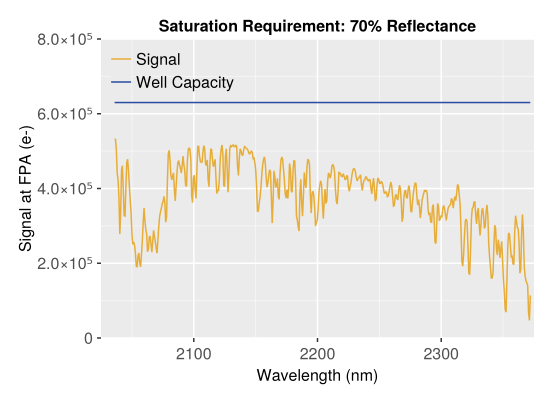

In [124]:
# Show signal at FPA

f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Radiance (mW/nm/sr/m2)",  title="Radiance")

q4=forward_model_x_(x, 
						 sun=solarIrr_cbe, 
						 instrument=cbe_specs.instrument_kernel,
			             reflectance=0.7, 
			             sza=0, 
			             σ_matrix=σ_matrix, 
					     profile=profile,
			             wl=cbe_specs.modelling_wl)

lines!(ax,cbe_specs.instrument_wl,q4,color=CarbonI_colors[1],label="Simulated Reflected Radiance")
#axislegend(ax,position = :lt)
xlims!(ax,2025,2375)
ylims!(ax,0,24)
save("/Users/drt/src/CarbonI-drt/plots/final/SaturationRadiance.pdf",f)
f
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Radiance (mW/nm/sr/m2)",  title="Radiance")
signal = InstrumentOperator.photons_at_fpa(ins_cbe, (cbe_specs.instrument_wl)u"nm", (q4)u"mW/m^2/nm/sr")
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Signal at FPA (e-)",  title="Saturation Requirement: 70% Reflectance")
lines!(ax,cbe_specs.instrument_wl,signal,color=CarbonI_colors[1],label="Signal")
lines!(ax,cbe_specs.instrument_wl,0.0.*cbe_specs.instrument_wl.+630000,color=CarbonI_colors[4],label="Well Capacity")
xlims!(ax,2025,2375)
ylims!(ax,0,800000)
axislegend(ax,position = :lt)
save("/Users/drt/src/CarbonI-drt/plots/final/SaturationSignalAtFPA.pdf",f)
f

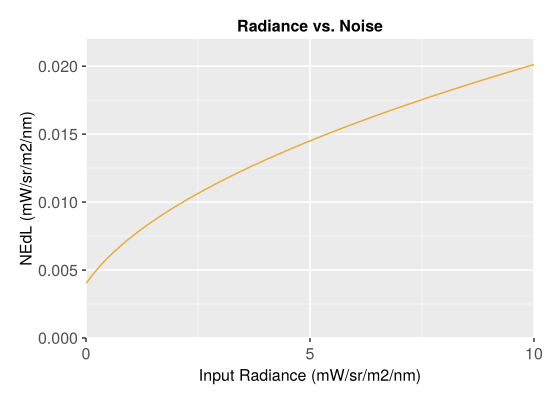

In [125]:
# Show Noise at different radiance levels
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Radiance (mW/nm/sr/m2)",  title="Radiance")
r = []
Ls = []
L = 0.01:0.01:10
for i in L
    NEdL = InstrumentOperator.noise_equivalent_radiance(ins_cbe, (cbe_specs.instrument_wl)u"nm", (i)u"mW/m^2/nm/sr")
    push!(r,NEdL[100]) 
    push!(Ls,i)
end
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Input Radiance (mW/sr/m2/nm)", ylabel="NEdL (mW/sr/m2/nm)",  title="Radiance vs. Noise")
lines!(ax,Vector{Float32}(Ls),Vector{Float32}(r/1u"mW/nm/m^2/sr"),color=CarbonI_colors[1],label="Noise")
#lines!(ax,cbe_specs.instrument_wl,0.0.*cbe_specs.instrument_wl.+630000,color=CarbonI_colors[4],label="Well Capacity")
xlims!(ax,0,10)
ylims!(ax,0,0.022)
save("/Users/drt/src/CarbonI-drt/plots/final/NoiseVsRadiance.pdf",f)
f

### The End